Imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from typing import Tuple

The grid is represented by the "GridWorld" class:

In [3]:
class Direction(Enum):
    RIGHT = (0, 1)
    LEFT = (0, -1)
    UP = (-1, 0)
    DOWN = (1, 0)


class GridWorld:

    def __init__(self):
        self.state_dtype = np.dtype([('key', 'U2'), ('state_value', 'f4')])
        self.grid = np.array([[(None, 0) for _ in range(5)]
                             for _ in range(5)], dtype=self.state_dtype)
        self.grid[0, 1]['key'] = 'A'
        self.grid[0, 3]['key'] = 'B'
        self.grid[4, 1]['key'] = 'A_'
        self.grid[2, 3]['key'] = 'B_'

    def move(self, position, direction: Direction):
        # basically (pos[0]+dir[0], pos[1]+dir[1])
        new_position = tuple(sum(x) for x in zip(position, direction.value))

        if self.grid[position]['key'] == 'A':
            new_position = (4,1)
            return 10, new_position

        elif self.grid[position]['key'] == 'B':
            new_position = (2,3)
            return 5, new_position
        
        if new_position[0] < 0 or new_position[1] < 0 or new_position[0] > 4 or new_position[1] > 4:
            return -1, position
        else:
            return 0, new_position

    def get_state_value_after_move(self, position, direction):
        '''
        Gets the state value of the cell which the player would be on after moving in the provided direction. The function does not actually move the player and thus does not return a new position.
        '''

        if self.grid[position]['key'] == 'A':
            return self.grid[(4, 1)]['state_value']
        
        if self.grid[position]['key'] == 'B':
            return self.grid[(2, 3)]['state_value']
        
        new_position = tuple(sum(x) for x in zip(position, direction.value))

        if new_position[0] < 0 or new_position[1] < 0 or new_position[0] > 4 or new_position[1] > 4:
            return -np.inf
        
        return self.grid[new_position]['state_value']

    def reset(self):
        self.grid = np.array([[(None, 0) for _ in range(5)] for _ in range(5)], dtype=self.state_dtype)
        self.grid[0, 1]['key'] = 'A'
        self.grid[0, 3]['key'] = 'B'
        self.grid[4, 1]['key'] = 'A_'
        self.grid[2, 3]['key'] = 'B_'

    def __str__(self):
        print_string = '--- GRID ---\n'
        for row in self.grid:
            print_string += '- ' * len(self.grid[0]) * 5
            print_string += '\n'

            print_string += '|'
            for cell in row:
                cell_value = cell['state_value']

                # create equal spacing for printing    
                value_prefix = ' ' if cell_value > 0 else ''
                value_prefix = '' if cell_value >= 10 else value_prefix
                cell_value = round(cell_value, 4)
                print_string += f' {value_prefix}{cell_value:.4f} |'
            
            print_string += '\n'
        print_string += '- ' * len(self.grid[0]) * 5
        print_string += '\n--- END GRID ---\n'

        return print_string

    def __repr__(self):
        return self.__str__()

        

Create the class which represents the policy for each cell. Basically holds an array for the possible actions for each cell. If there are more than one action, each one has the same probability of being taken:

In [4]:
class CellPolicy:
    
    def __init__(self, initial_choices):
        self.choices = np.array(initial_choices)

    def update(self, new_choices):
        self.choices = np.array(new_choices) 

    def get_choices(self) -> np.ndarray:
        return self.choices
    
    def __str__(self):
        choices_to_sign_map = [None, # cannot happen would mean that no action is possible
                               '🡢', # left
                               '🡠', # right
                               '⮂', # left + right
                               '🡡', # up
                               '🡥', # up + right
                               '🡤', # up + left
                               '⤧', # up + right + left
                               '🡣', # down
                               '🡦', # down + right
                               '🡧', # down + left
                               '⤩', # down + right + left
                               '⮁', # up + down
                               '⤨', # right + up + down
                               '⤪', # left + up + down
                               '⬤'] # all directionsS
        
        enum_val_map = {
            Direction.RIGHT : 0,
            Direction.LEFT : 1,
            Direction.UP : 2,
            Direction.DOWN : 3
        }

        mapped_directions = np.array([enum_val_map[direction] for direction in self.choices])
        occurences = np.zeros((4,))
        occurences[mapped_directions] = 1

        # calculate a unique index [1-15] for each combination of possible actions
        index = 0
        for i in range(len(occurences)):
            index+=2**i * occurences[i]

        return choices_to_sign_map[int(index)]
    
    def __repr__(self):
        return self.__str__()

Simple print function for the policy grid:

In [5]:
def print_policy(policy):
    print('--- POLICY ---')
    for row in policy:
        print('- ' * 12)
        print('|', end='')
        for cell_policy in row:
            print(f' {cell_policy} |', end='')
        
        print()
    print('- ' * 12)
    print('--- END POLICY ---')
    print()

Define a function for updating the policy based on the current grid:

In [6]:
def update_policy(policy : np.ndarray, grid_world : GridWorld) -> Tuple[np.ndarray, bool]:
    changed_policy = False
    for index, cell_policy in np.ndenumerate(policy):
        actions = policy[index].get_choices()
        corresponding_state_values = np.array([grid_world.get_state_value_after_move(index, action) for action in actions])
        max_state_value = np.max(corresponding_state_values)
        max_indices = np.where(corresponding_state_values == max_state_value)
        corresponding_state_values = corresponding_state_values[max_indices]
        if len(corresponding_state_values) < len(actions):
            changed_policy = True
            cell_policy.update(actions[max_indices])
        
    return policy, changed_policy

### Task 3.1 a) - Update the policy only after state value convergence

In [ ]:
grid_world = GridWorld()
discount = 0.9

# initially: random policy
policy = np.array([[CellPolicy([Direction.UP, Direction.RIGHT, Direction.DOWN, Direction.LEFT]) for _ in range(5)] for _ in range(5)])

changed_policy = True
while(changed_policy):

    grid_world.reset()
    diff = np.inf
    
    it = 0
    # calculate the state values
    while(diff > 0.001):
        it += 1
        diff = 0.0
        for index, value in np.ndenumerate(grid_world.grid):
            new_value = 0
            possible_actions = policy[index].get_choices()
            for action in possible_actions:
                reward, next_state = grid_world.move(index, action)
                new_value += (1 / len(possible_actions)) * (reward + discount *
                                        grid_world.grid[next_state]['state_value'])
            
            new_diff = abs(new_value - value['state_value'])
            diff = max(diff, new_diff)

            grid_world.grid[index]['state_value'] = new_value


    # update the policy    
    policy, changed_policy = update_policy(policy, grid_world)  
    print(f'Took {it} iterations for state value convergence.')


print_policy(policy)
print(grid_world)

Took 30 iterations for state value convergence.
Took 28 iterations for state value convergence.
--- POLICY ---
- - - - - - - - - - - - 
| 🡢 | ⬤ | 🡠 | ⬤ | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
--- END POLICY ---

--- GRID ---
- - - - - - - - - - - - - - - - - - - - - - - - - 
| 21.9775 | 24.4194 | 21.9775 | 18.4475 | 16.6028 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| 19.7797 | 21.9775 | 19.7797 | 16.6028 | 14.9425 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| 17.8018 | 19.7797 | 17.8018 | 14.9425 | 13.4483 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| 16.0216 | 17.8018 | 16.0216 | 13.4483 | 12.1034 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| 14.4194 | 16.0216 | 14.4194 | 12.1034 | 10.8931 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
--- END GRID ---



### Task 3.1 b) - Update the policy after each state value iteration:

In [6]:
grid_world = GridWorld()
discount = 0.9
diff_arr = []

# initially: random policy
policy = np.array([[CellPolicy([Direction.UP, Direction.RIGHT, Direction.DOWN, Direction.LEFT]) for _ in range(5)] for _ in range(5)])

diff = np.inf
changed_policy = True

print('Initial policy:')
print_policy(policy)

# calculate the state values
iteration_count = 0
while(diff > 0.001):
    iteration_count += 1
    diff = 0.0
    for index, value in np.ndenumerate(grid_world.grid):
        new_value = 0
        possible_actions = policy[index].get_choices()
        for action in possible_actions:
            reward, next_state = grid_world.move(index, action)
            new_value += (1 / len(possible_actions)) * (reward + discount *
                                    grid_world.grid[next_state]['state_value'])
        
        new_diff = abs(new_value - value['state_value'])
        diff = max(diff, new_diff)

        grid_world.grid[index]['state_value'] = new_value

    # after each iteration for the state values: update the policy
    policy, _ = update_policy(policy, grid_world)  

    print(f'--- After iteration {iteration_count} --- ')
    print_policy(policy)
    print(grid_world)

    diff_arr.append(diff)

Initial policy:
--- POLICY ---
- - - - - - - - - - - - 
| ⬤ | ⬤ | ⬤ | ⬤ | ⬤ |
- - - - - - - - - - - - 
| ⬤ | ⬤ | ⬤ | ⬤ | ⬤ |
- - - - - - - - - - - - 
| ⬤ | ⬤ | ⬤ | ⬤ | ⬤ |
- - - - - - - - - - - - 
| ⬤ | ⬤ | ⬤ | ⬤ | ⬤ |
- - - - - - - - - - - - 
| ⬤ | ⬤ | ⬤ | ⬤ | ⬤ |
- - - - - - - - - - - - 
--- END POLICY ---

--- After iteration 1 --- 
--- POLICY ---
- - - - - - - - - - - - 
| 🡢 | ⬤ | 🡠 | ⬤ | 🡠 |
- - - - - - - - - - - - 
| 🡢 | 🡡 | 🡠 | 🡡 | 🡠 |
- - - - - - - - - - - - 
| 🡢 | 🡡 | 🡡 | 🡡 | 🡠 |
- - - - - - - - - - - - 
| 🡢 | 🡡 | 🡡 | 🡡 | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
--- END POLICY ---

--- GRID ---
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.5000 | 10.0000 |  2.0000 |  5.0000 |  0.6250 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.3625 |  2.1684 |  0.9379 |  1.3360 |  0.1912 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.3316 |  0.4133 |  0.3040 |  0.3690 | -0.1239 |
- - - - - - - - - - - - - - - - - - - - - - -

### Task 3.1 c) - Using the Action Value Function

Map a direction (action) to a certain index. This becomes important when certain actions are removed from the policy but we still want to map the existing ones to the correct locations in the action value array.

In [8]:
def get_index_for_action(action : Direction):
    dir_index_map = {
        Direction.RIGHT : 0,
        Direction.LEFT : 1,
        Direction.UP : 2,
        Direction.DOWN : 3
    }

    return dir_index_map[action]


Create a function for updating the policy based on the action values.
Principle (done for each cell):
1. Get the action values for the current cell
2. Use the action to index mapping to only get the action values for the remaining actions
3. Get the indices of the highest action values
4. If necessary: Remove actions from the cell policy which are no longer optimal

In [9]:
def update_policy_av(policy, action_values) -> Tuple[np.ndarray, bool]:
    changed_policy = False
    for index, cell_policy in np.ndenumerate(policy):
        actions = policy[index].get_choices()
        action_indices = [get_index_for_action(action) for action in actions]
        corresponding_action_values = action_values[index][action_indices]
        max_action_value = np.max(corresponding_action_values)
        max_indices = np.where(corresponding_action_values == max_action_value)
        corresponding_action_values = corresponding_action_values[max_indices]
        if len(corresponding_action_values) < len(actions):
            changed_policy = True
            cell_policy.update(actions[max_indices])

    return policy, changed_policy

Now optimize the policy based on the converged action values:

Convergence for action values took 27 iterations
Convergence for action values took 28 iterations
--- POLICY ---
- - - - - - - - - - - - 
| 🡢 | ⬤ | 🡠 | ⬤ | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡠 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
| 🡡 | 🡡 | 🡡 | 🡡 | 🡡 |
- - - - - - - - - - - - 
--- END POLICY ---



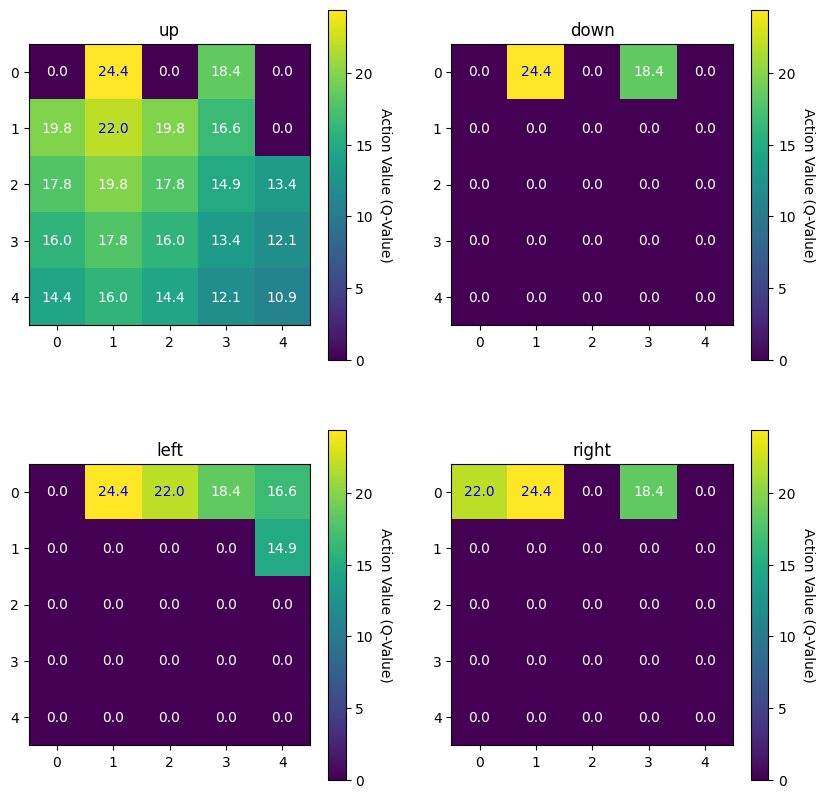

In [65]:
grid_world = GridWorld()
iterations = 15
discount = 0.9
action_value_arr = np.zeros((5, 5, 4))
diff_arr = []

# initially: random policy
policy = np.array([[CellPolicy([Direction.RIGHT, Direction.LEFT, Direction.UP, Direction.DOWN]) for _ in range(5)] for _ in range(5)])

def get_action_value(policy, action, state_index, action_value_arr):
    new_value = 0
    reward, next_state = grid_world.move(state_index, action)
    possible_actions = policy[next_state].get_choices()
    for action in possible_actions:
        idx = get_index_for_action(action);
        action_value_arr_index = next_state + (idx,)
        new_value += 1 / len(possible_actions) * (action_value_arr[action_value_arr_index])
    return reward + discount * new_value

changed_policy = True
it = 0
while changed_policy:
    it += 1
    diff = np.inf
    action_value_arr = np.zeros((5, 5, 4))
    
    # let the action values converge
    action_value_it = 0
    while(diff > 0.001):
        action_value_it += 1
        diff = 0
        for index, _ in np.ndenumerate(grid_world.grid):
            new_value = 0
            possible_actions = policy[index].get_choices()
            for action in possible_actions:
                action_idx = get_index_for_action(action)
                new_value = get_action_value(policy, action, index, action_value_arr)
                
                new_diff = abs(new_value - action_value_arr[index + (action_idx,)])
                diff = max(diff, new_diff)
                
                action_value_arr[index + (action_idx,)] = new_value
        
    print(f'Convergence for action values took {action_value_it} iterations')

    policy, changed_policy = update_policy_av(policy, action_value_arr)    
    
print_policy(policy)

# plot resulting value functions
custom_dtype = np.dtype([('data', np.ndarray), ('description', 'U5')])
ax_vals = np.array([
    [
        (action_value_arr[:,:,get_index_for_action(Direction.UP)], 'up'),
        (action_value_arr[:,:,get_index_for_action(Direction.DOWN)], 'down')
    ],
    [
        (action_value_arr[:,:,get_index_for_action(Direction.LEFT)], 'left'),
        (action_value_arr[:,:,get_index_for_action(Direction.RIGHT)], 'right')
    ]
], dtype=custom_dtype)

figure, axes = plt.subplots(2,2, figsize=(10,10))

# Loop over data dimensions and create text annotations.
for ax_index, ax in np.ndenumerate(axes):
    im = ax.imshow(ax_vals[ax_index]['data'])
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Action Value (Q-Value)', rotation=-90, va="bottom")
    ax.set_title(ax_vals[ax_index]['description'])
    for i in range(5):
        for j in range(5):
            text_color = 'w' if round(ax_vals[ax_index]["data"][i, j],1)<20 else 'b'
            text = ax.text(j, i, f'{round(ax_vals[ax_index]["data"][i, j],1)}', ha="center", va="center", color=text_color)

